# Kr NEW Compare KrMap - ICAROS Map

J. A Hernando, C. Herves

May 2022

In [1]:
%matplotlib inline 

#%matplotlib notebook
#matplotlib widget
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy             as np
import pandas            as pd
import tables            as tb
from   scipy             import stats
from   scipy             import optimize

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

plt.rcParams['image.cmap'] = 'rainbow'

In [3]:
import hipy.utils        as ut
import hipy.pltext       as pltext
import hipy.profile      as prof

import nana.kr.krana    as krana
import nana.kr.icaros   as icaros

#import nana.bclouds.bclouds      as bc
#import hipy.hfit         as hfit
from invisible_cities.io.dst_io import load_dst, load_dsts
#import invisible_cities.io.dst_io as dio

In [4]:
pltext.style()

import warnings
warnings.filterwarnings('ignore')

import time
print(' Last revision ', time.asctime())

 Last revision  Fri May  6 16:28:33 2022


In [5]:
#import os
import re
import glob

from collections import namedtuple

## Access Data

In [6]:
path = '/Users/hernando/work/investigacion/NEXT/data/NEW/Kr/'
runs = 8182, 8183, 8184, 8851

In [7]:
from os import listdir

run = 8182
filenames = listdir(path+str(run))
filenames.sort()
print(len(filenames), filenames[0], filenames[-1])
filenames = [path + str(run) + '/' + ifile for ifile in filenames]

8499 kdst_0000_8182_trigger1_v1.2.0_20191122_krbg.h5 kdst_8498_8182_trigger1_v1.2.0_20191122_krbg.h5


In [8]:
mapfilename = path + 'maps/map_' + str(run) + '.h5'

In [9]:
icaromap = icaros.get_map(mapfilename)

In [10]:
kdst = load_dsts(filenames, "DST", "Events")

In [11]:
kdst.columns

Index(['event', 'time', 's1_peak', 's2_peak', 'nS1', 'nS2', 'S1w', 'S1h',
       'S1e', 'S1t', 'S2w', 'S2h', 'S2e', 'S2q', 'S2t', 'Nsipm', 'DT', 'Z',
       'Zrms', 'X', 'Y', 'R', 'Phi', 'Xrms', 'Yrms'],
      dtype='object')

In [12]:
names = ['event', 'time', 'S2e', 'X', 'Y', 'Z', 'DT']
sel   = (kdst.nS1 == 1) & (kdst.nS2 == 1)
mkdst = kdst[sel][names]
mkdst['R'] = np.sqrt(mkdst.X**2 + mkdst.Y**2)
mkdst.replace(np.nan, 0.)
mkdst = mkdst.rename(columns = {'S2e' : 'energy', 'X' : 'x', 'Y' : 'y', 'Z' : 'z', 'DT' : 'dtime', 'R' : 'r'})

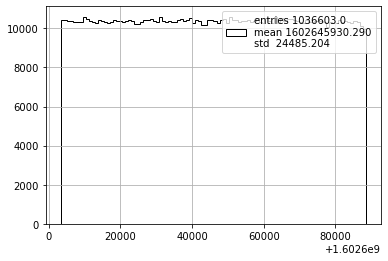

In [13]:
pltext.hist(mkdst.time, 100);

In [14]:
sels = {}
sels['r']        = ut.in_range(mkdst.r  , (0., 180))
sels['dtime']    = ut.in_range(mkdst.dtime , (20, 550.))
sels['energy']   = ut.in_range(mkdst.energy, (6e3, 12.5e3))
sels['fidutial'] = (sels['r']) & (sels['dtime']) & (sels['energy'])

In [15]:
mkdst.columns

Index(['event', 'time', 'energy', 'x', 'y', 'z', 'dtime', 'r'], dtype='object')

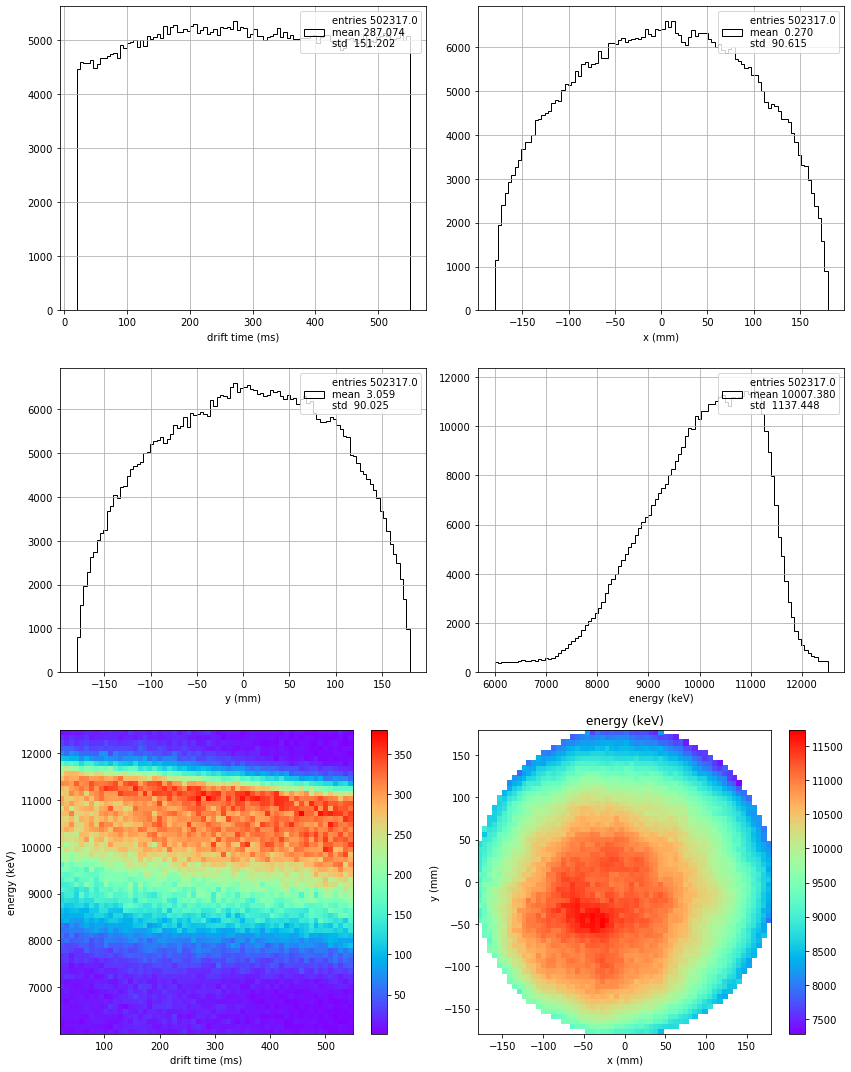

In [16]:
sel = sels['fidutial']
krana.plot_data(mkdst[sel], 60)

In [19]:
def _accept_residuals(krmap):
    xsel = ~np.isnan(krmap.residuals)
    canvas = pltext.canvas(2, 2)
    canvas(1)
    pltext.hist(krmap.residuals[xsel], 100);
    plt.yscale('log');
    plt.xlabel('normalized residuals');
    canvas(2)
    cc = pltext.hfit(krmap.residuals[xsel], 100, 'gaus');
    pars = cc[3]
    sigma = pars[2]
    print('sigma ', sigma)
    plt.yscale('log'); plt.ylim((1, 1e5));
    plt.xlabel('normalized residuals');
    plt.show()
    sigma  = 3.5 * sigma 
    #sigma = input('sigma of the accepted residuals (>=5 (all)) ')
    done  = sigma > 3.4
    print('done ', done)
    sel   = xsel if done else np.abs(krmap.residuals) <= sigma
    return done, sel

sigma  0.36012348264063576


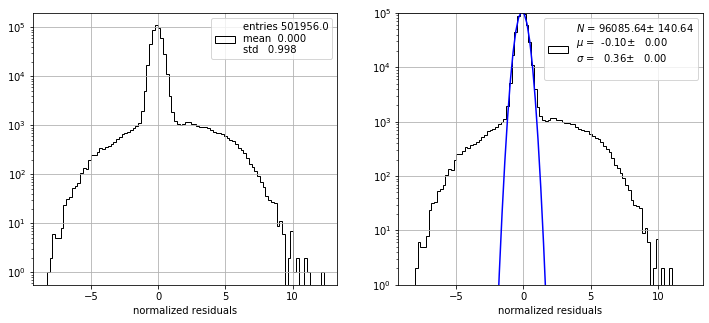

done  False
cleanning  False 469662 0.45307798646154795
sigma  0.964445226851717


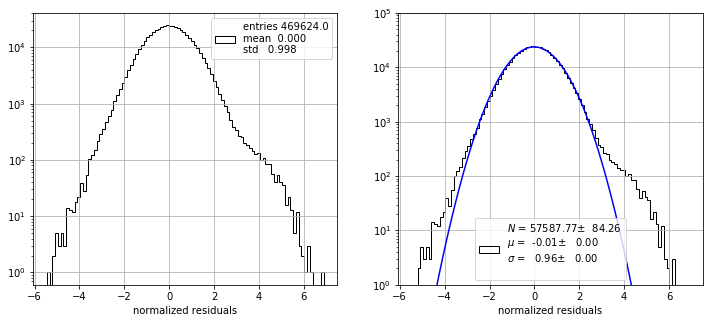

done  False
cleanning  False 467694 0.4511794775820637
sigma  0.9921385434057075


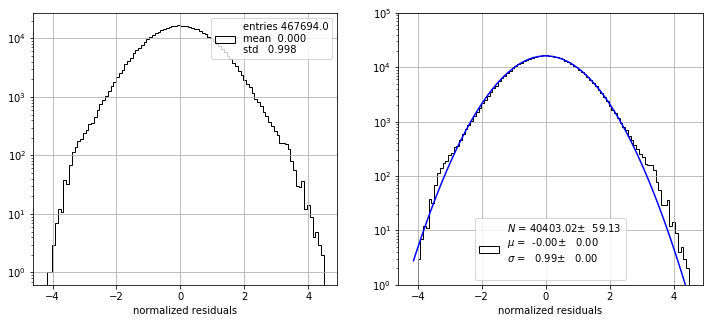

done  True
cleanning  True 467694 0.4511794775820637
len  1036603 1036603


In [20]:
counts_min = 40
grain      = 2

clean = np.copy(sel)
done  = False
while (not done):
    coors  = mkdst[clean].x, mkdst[clean].y
    energy = mkdst[clean].energy
    dtime  = mkdst[clean].dtime
    krmap  = krana.krmap(coors, dtime, energy, bins = (18 * grain, 18 * grain), 
                         counts_min = counts_min, dt0 = None)
    done, usel = _accept_residuals(krmap)
    clean[clean == True] = usel
    print('cleanning ', done, np.sum(clean), np.sum(clean)/len(clean))

print('len ', len(clean), len(sel))
sels['residuals'] = clean

## Kr Map

In [21]:
sel    = sels['residuals']
coors  = mkdst[sel].x, mkdst[sel].y
energy = mkdst[sel].energy
dtime  = mkdst[sel].dtime
counts_min = 40
grain  = 2
krmap  = krana.krmap(coors, dtime, energy, bins = (18 * grain, 18 * grain), counts_min = counts_min, dt0 = None)

## residuals

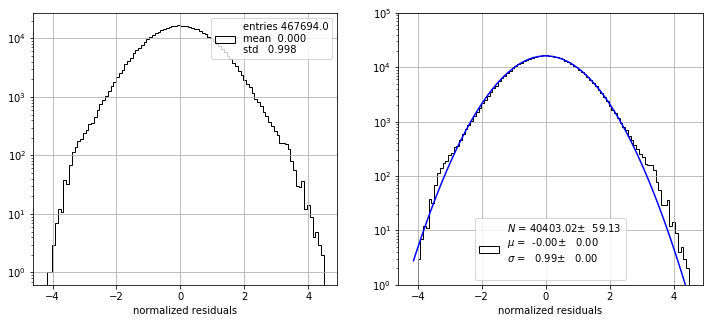

In [22]:
xsel = ~np.isnan(krmap.residuals)
canvas = pltext.canvas(2, 2)
canvas(1)
pltext.hist(krmap.residuals[xsel], 100);
plt.yscale('log');
plt.xlabel('normalized residuals');
canvas(2)
pltext.hfit(krmap.residuals[xsel], 100, 'gaus');
plt.yscale('log'); plt.ylim((1, 1e5));
plt.xlabel('normalized residuals');

## Kr map 

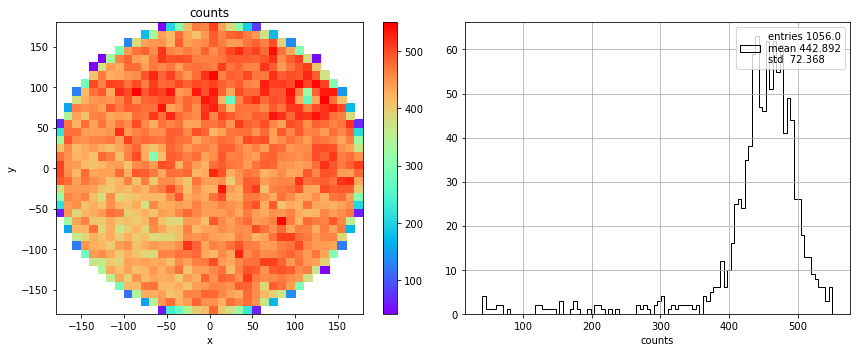

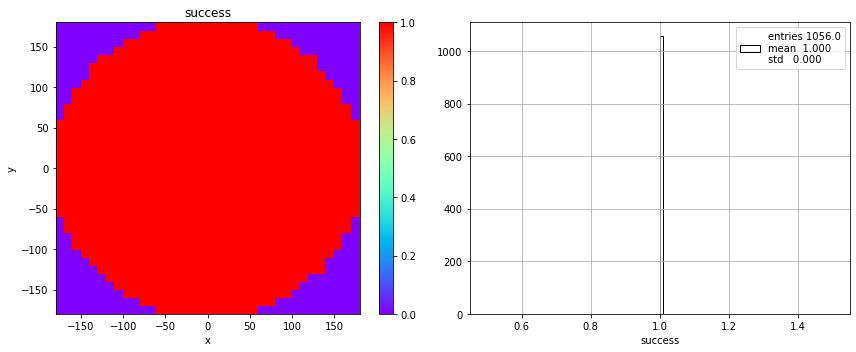

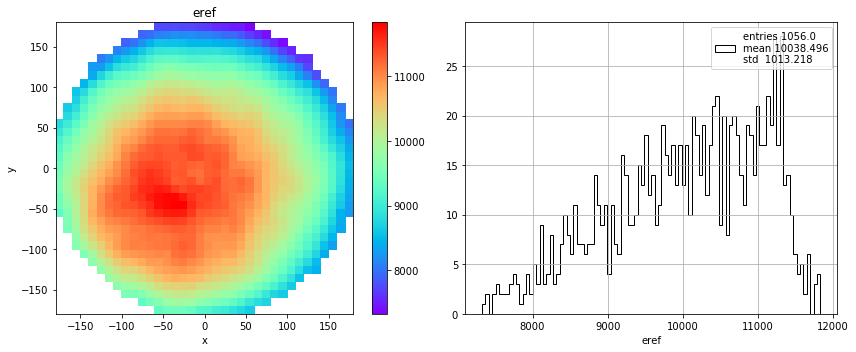

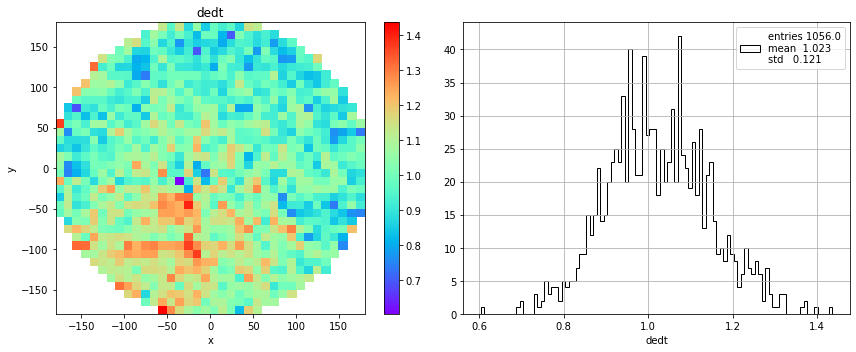

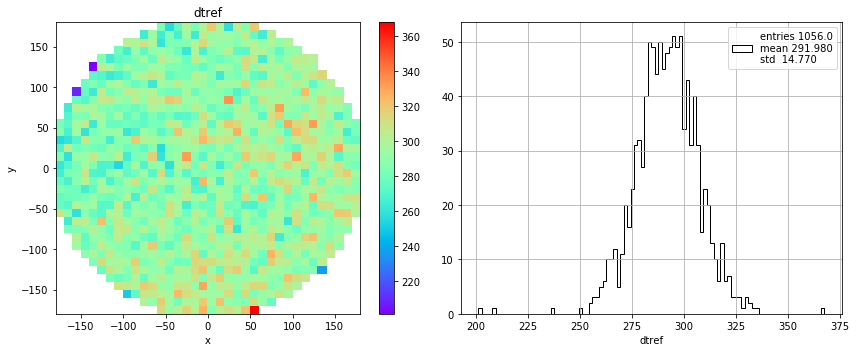

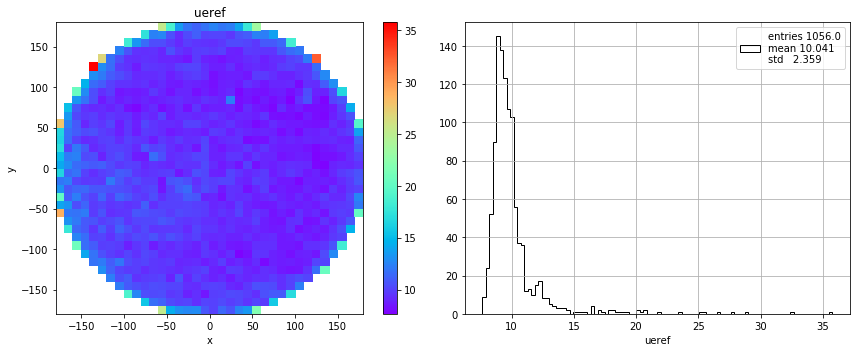

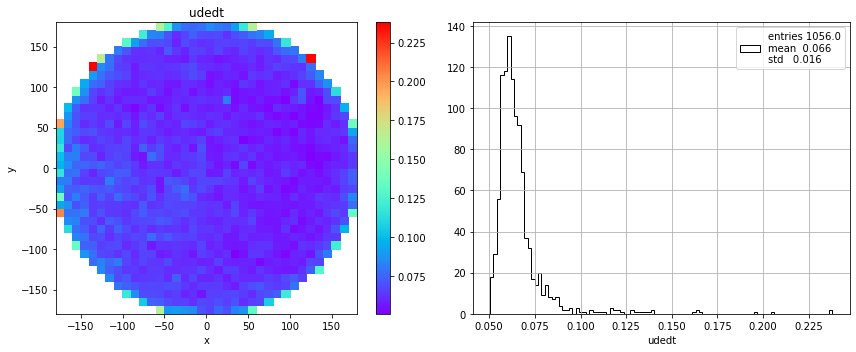

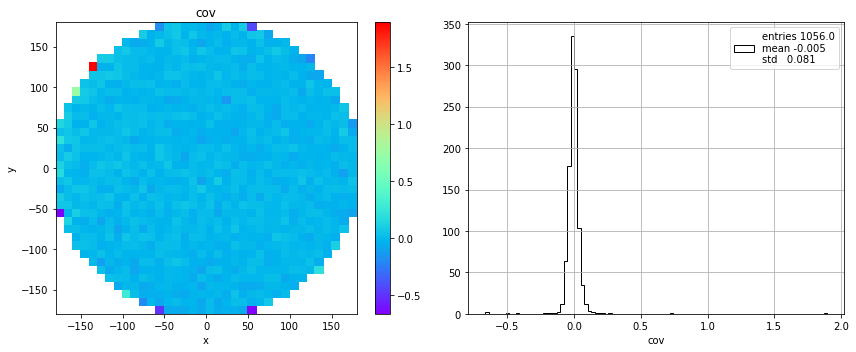

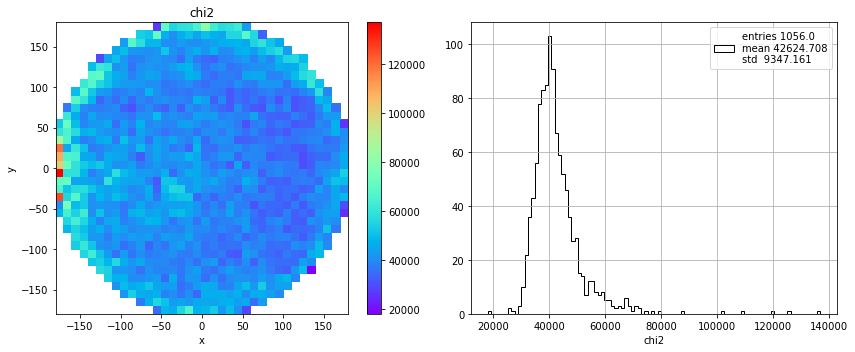

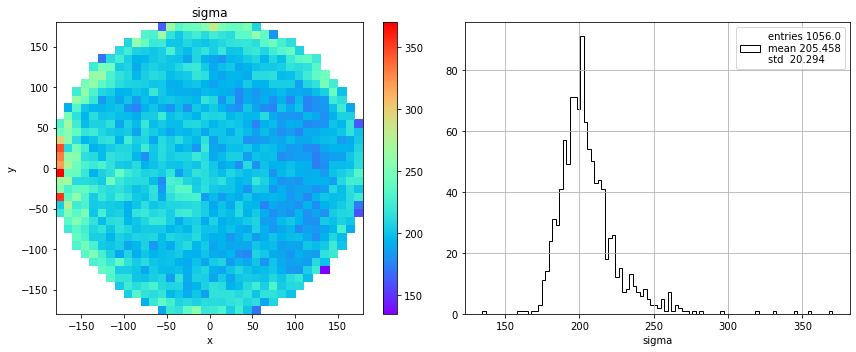

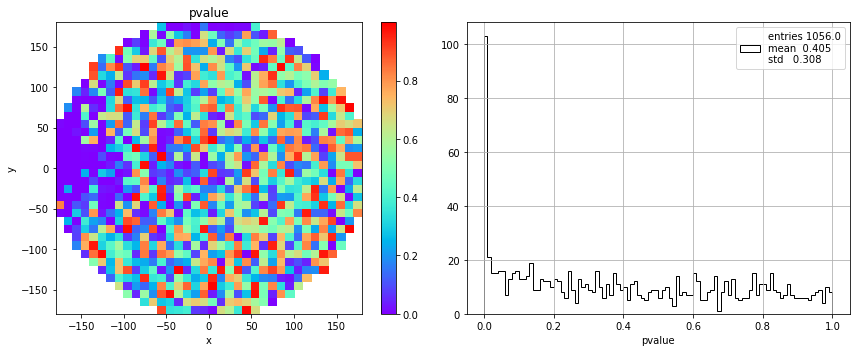

In [23]:
krana.plot_xyvar(krmap.counts , krmap.bin_edges, 'counts' , mask = krmap.counts > 0)
krana.plot_xyvar(krmap.success, krmap.bin_edges, 'success', mask = krmap.success)
krana.plot_xyvar(krmap.eref   , krmap.bin_edges, 'eref'   , mask = krmap.success)
krana.plot_xyvar(krmap.dedt   , krmap.bin_edges, 'dedt'   , mask = krmap.success)
krana.plot_xyvar(krmap.dtref  , krmap.bin_edges, 'dtref'  , mask = krmap.success)
krana.plot_xyvar(krmap.ueref  , krmap.bin_edges, 'ueref'  , mask = krmap.success)
krana.plot_xyvar(krmap.udedt  , krmap.bin_edges, 'udedt'  , mask = krmap.success)
krana.plot_xyvar(krmap.cov    , krmap.bin_edges, 'cov'    , mask = krmap.success)
krana.plot_xyvar(krmap.chi2   , krmap.bin_edges, 'chi2'   , mask = krmap.success)
krana.plot_xyvar(krmap.sigma  , krmap.bin_edges, 'sigma'  , mask = krmap.success)
krana.plot_xyvar(krmap.pvalue , krmap.bin_edges, 'pvalue' , mask = krmap.success)

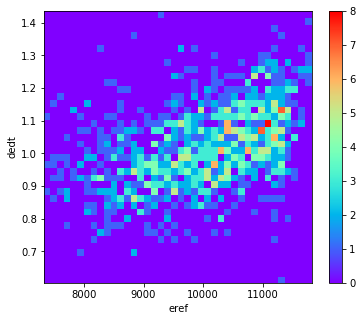

In [24]:
xsel = krmap.success
pltext.canvas(1, 1)
plt.hist2d(krmap.eref[xsel].ravel(), krmap.dedt[xsel].ravel(), (40, 40));
plt.colorbar(); plt.xlabel('eref'); plt.ylabel('dedt');

## Correction

In [25]:
corr_energy, _ = krana.krmap_scale(coors, dtime, energy, krmap, scale = 41.5)

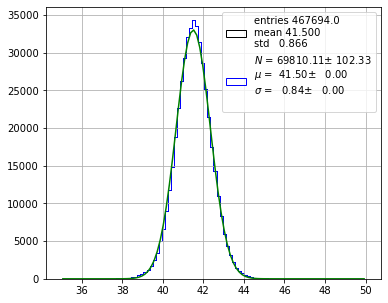

In [26]:
xsel = ~np.isnan(corr_energy)
pltext.canvas(1, 1);
pltext.hist(corr_energy[xsel], 100, (35., 50.));
pltext.hfit(corr_energy[xsel], 100, range = (35., 50.), fun = 'gaus');

## ICAROS energy

In [27]:
icaro_correction = icaros.get_correction(icaromap)

drift velocity  0.9248098826413511


In [31]:
sel    = sels['residuals']
coors  = mkdst[sel].x, mkdst[sel].y
energy = mkdst[sel].energy
dtime  = mkdst[sel].dtime
time   = mkdst[sel].time
#len(dtime), len(time), len(coors[0]), len(coors[1]), len(energy)
fs    = icaro_correction(*coors, dtime, time)
icaroene = energy * fs 
icaroene = 41.5 * icaroene/(np.mean(icaroene))
corene   = krana.krmap_scale(coors, dtime, energy, krmap, 41.5)

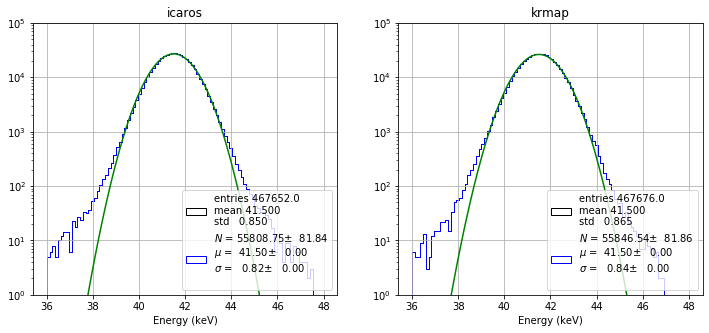

In [32]:
canvas = pltext.canvas(2, 2);
canvas(1)
pltext.hist(icaroene, 100, (36, 48));
pltext.hfit(icaroene, 100, range = (36, 48), fun = 'gaus');
plt.xlabel('Energy (keV)'); plt.title('icaros'); plt.yscale('log'); plt.ylim((1, 1e5));
canvas(2)
pltext.hist(corr_energy, 100, range = (36, 48)); plt.yscale('log'); plt.ylim((1, 1e5));
pltext.hfit(corr_energy, 100, range = (36, 48), fun = 'gaus');
plt.xlabel('Energy (keV)'); plt.title('krmap');

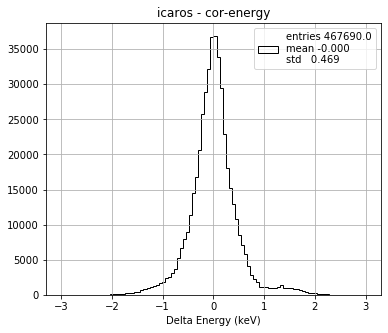

In [33]:
canvas = pltext.canvas(1, 1);
canvas(1)
dene = icaroene - corr_energy
pltext.hist(dene, 100, range = (-3., 3.));
plt.xlabel('Delta Energy (keV)'); plt.title('icaros - cor-energy');

In [34]:
sel          = sels['residuals']
size         = len(mkdst.energy)
icene        = np.nan * np.ones(size)
icene[sel]   = icaroene
corene       = np.nan * np.ones(size)
corene[sel]  = corr_energy
mkdst['icenergy']  = icene
mkdst['corenergy'] = corene
sels['corenergy']  = ut.in_range(corene, (30, 60));

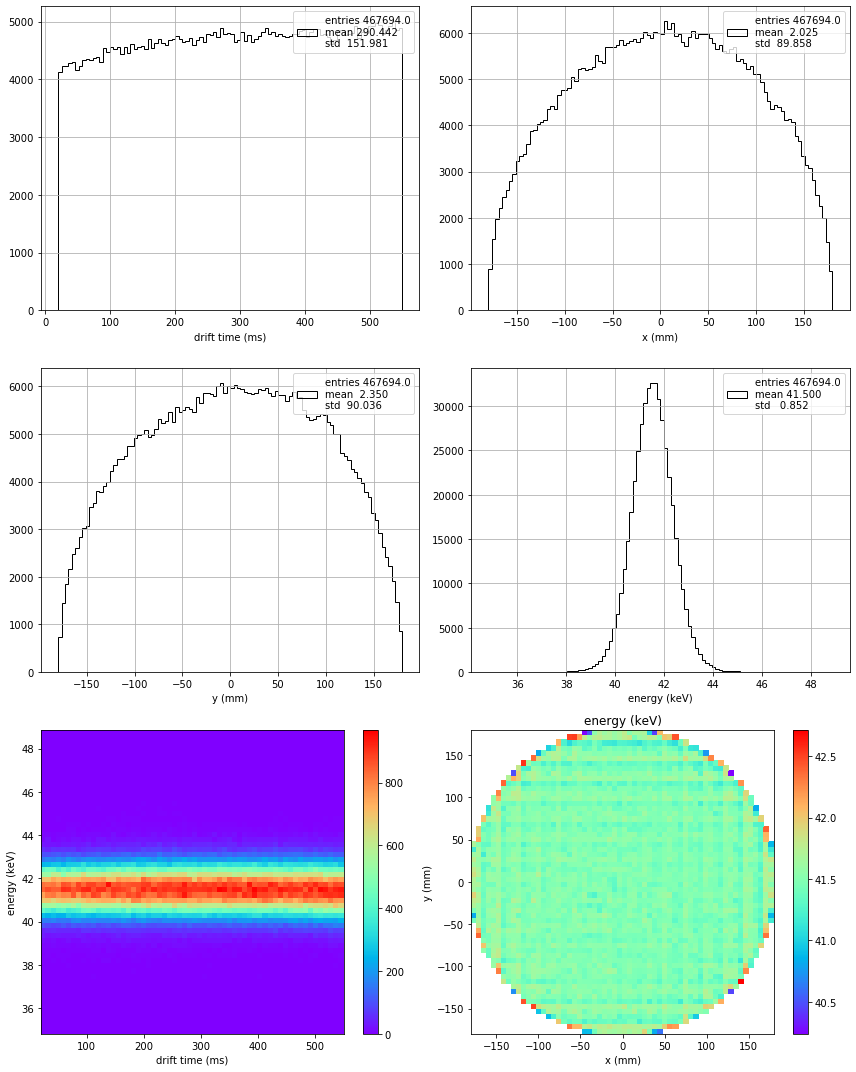

In [35]:
sel          = sels['corenergy']
df = {'x': mkdst[sel].x, 'y' : mkdst[sel].y, 'dtime': mkdst[sel].dtime, 'energy' : mkdst[sel].icenergy}
df = pd.DataFrame(df)
krana.plot_data(df, bins = 60)

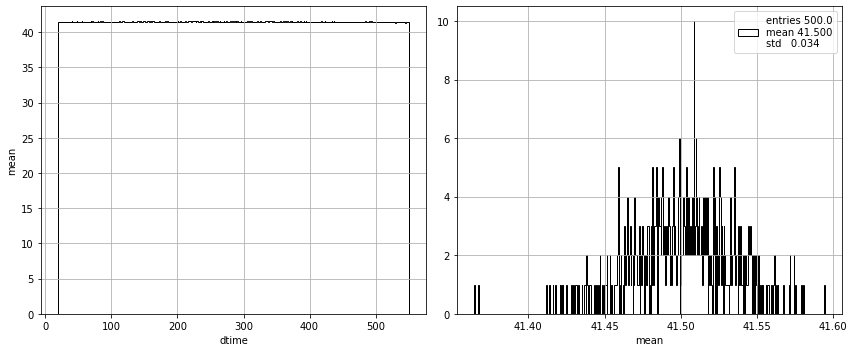

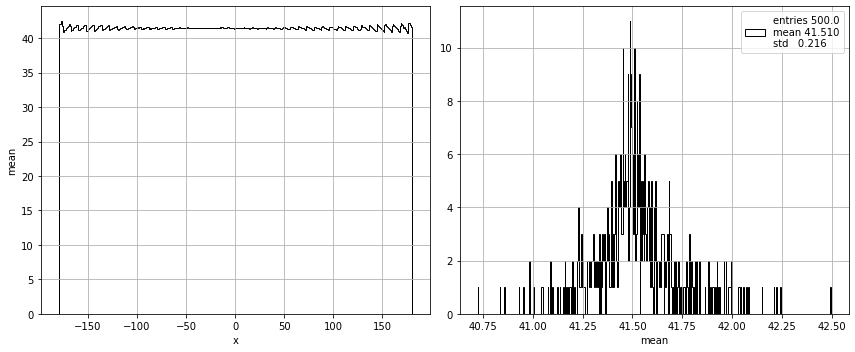

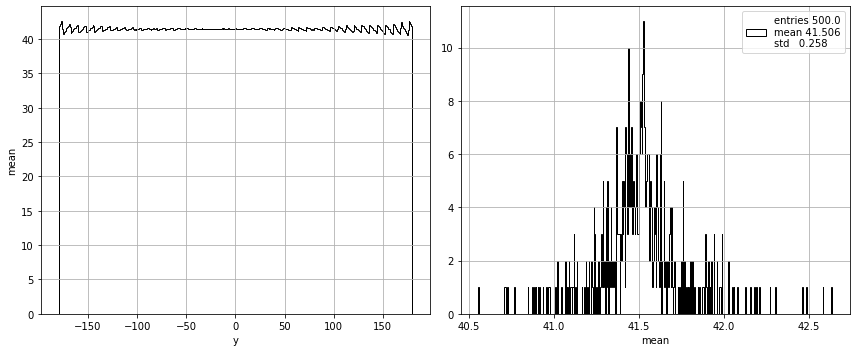

In [36]:
krana.plot_xydt_energy_profiles(df, nbins = 500)

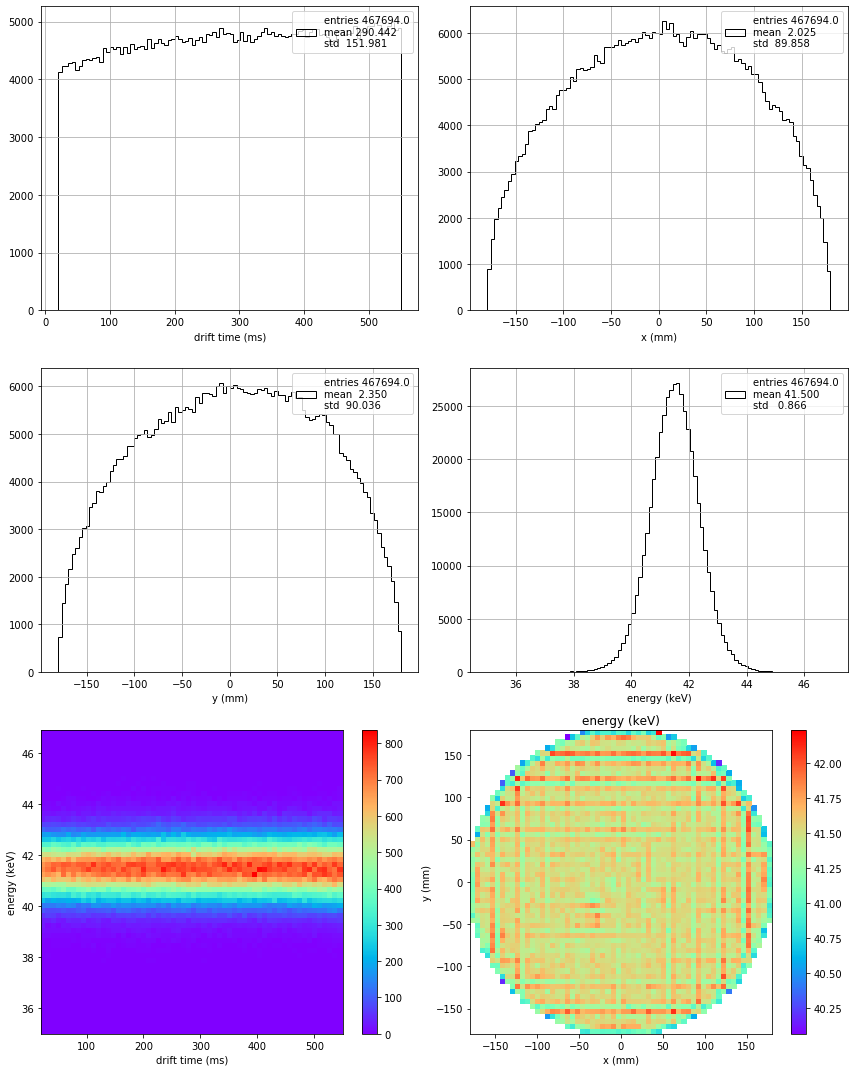

In [37]:
sel          = sels['corenergy']
df = {'x': mkdst[sel].x, 'y' : mkdst[sel].y, 'dtime': mkdst[sel].dtime, 'energy' : mkdst[sel].corenergy}
df = pd.DataFrame(df)
krana.plot_data(df, bins = 60)

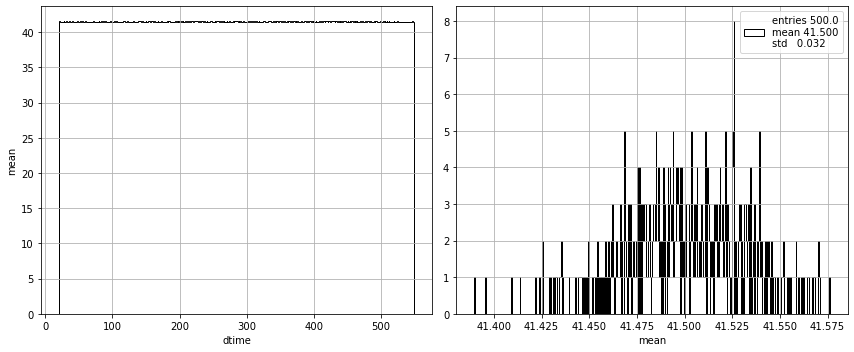

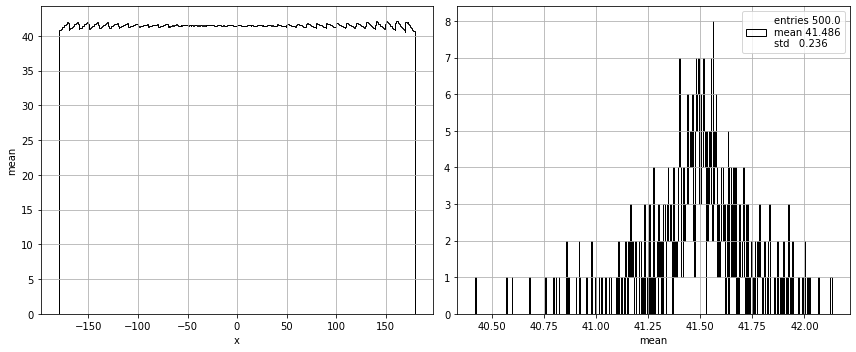

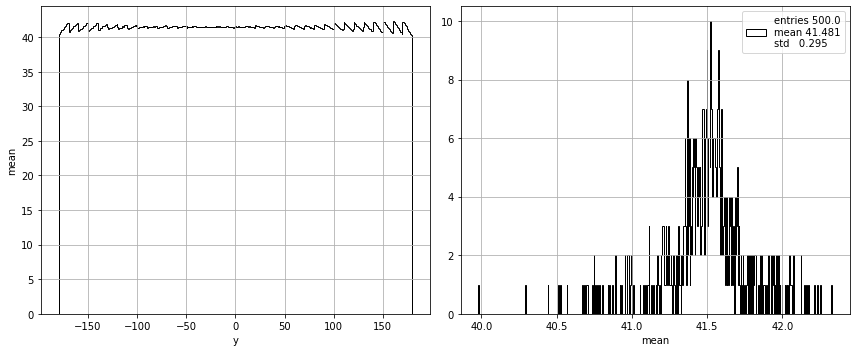

In [38]:
krana.plot_xydt_energy_profiles(df, nbins = 500)

## Refine the correction

In [39]:
sel    = sels['corenergy']
coors  = mkdst[sel].x, mkdst[sel].y
enes   = mkdst[sel].corenergy
xyprof = prof.profile(coors, enes, 180)

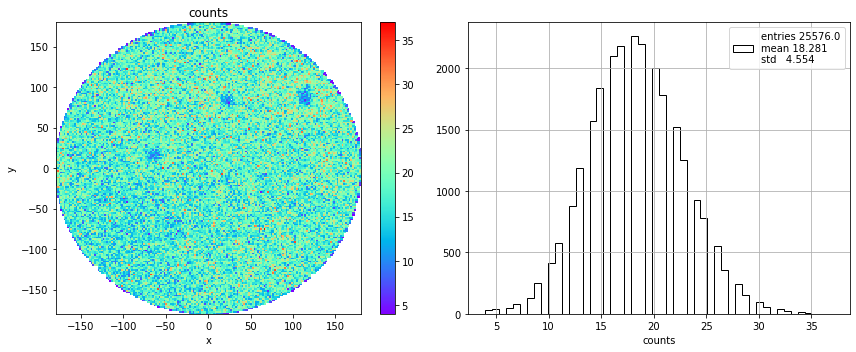

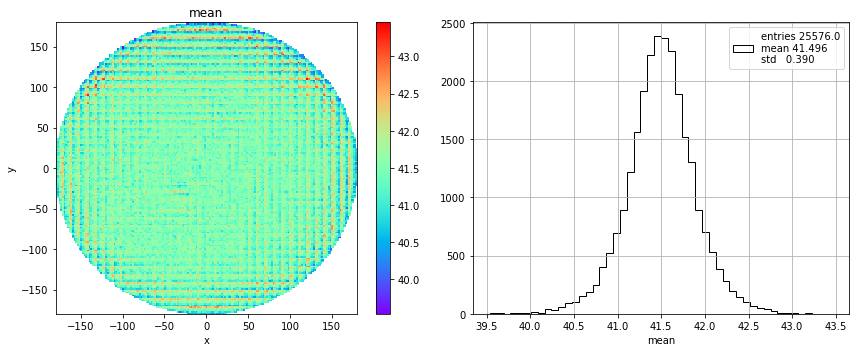

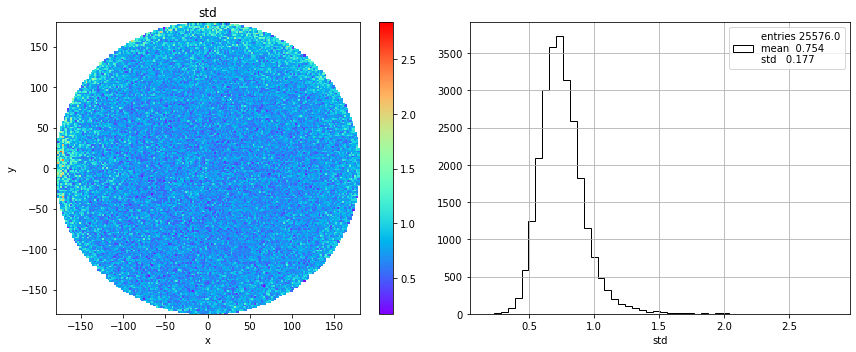

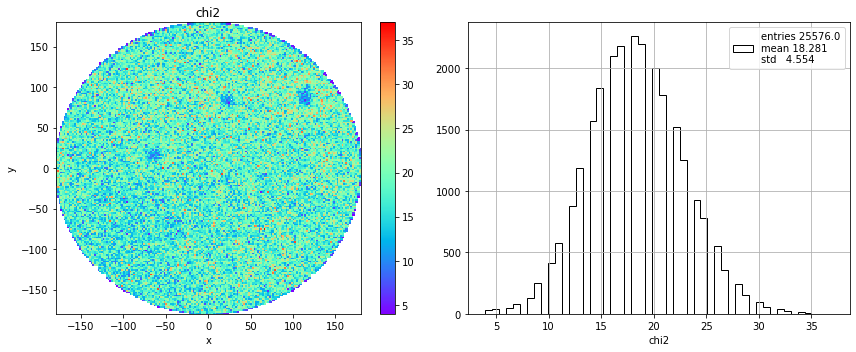

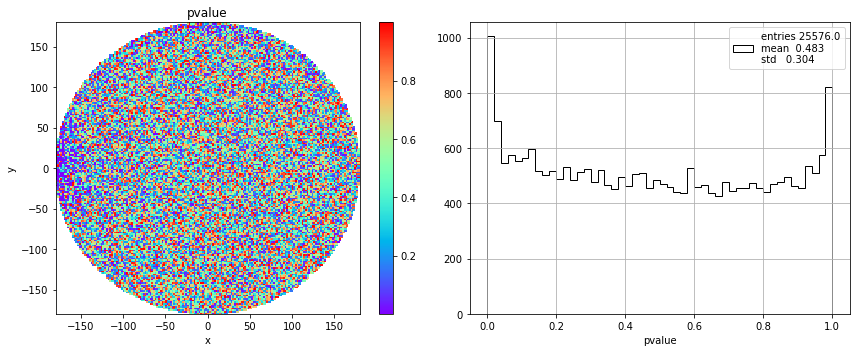

In [40]:
prof.plot_profile(xyprof);

In [41]:
corr2_energy = prof.profile_scale(coors, enes, xyprof, 41.5)
corene2      = np.nan * np.ones(size)
corene2[sel] = corr2_energy
mkdst['cor2energy'] = corene2

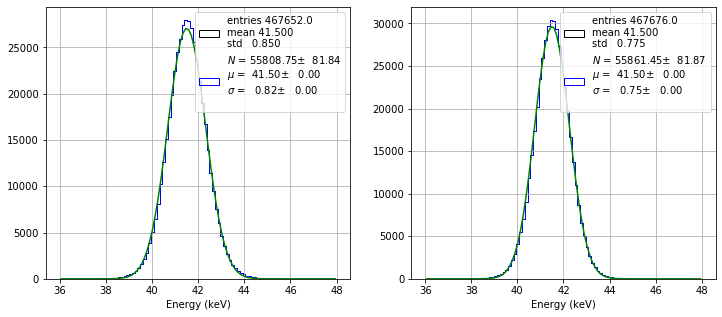

In [42]:
canvas = pltext.canvas(2, 2);
canvas(1)
pltext.hist(mkdst[sel].icenergy, 100, (36, 48));
pltext.hfit(mkdst[sel].icenergy, 100, range = (36, 48), fun = 'gaus');
plt.xlabel('Energy (keV)');
canvas(2)
pltext.hist(mkdst[sel].cor2energy, 100, (36, 48));
pltext.hfit(mkdst[sel].cor2energy, 100, range = (36, 48), fun = 'gaus');
plt.xlabel('Energy (keV)');

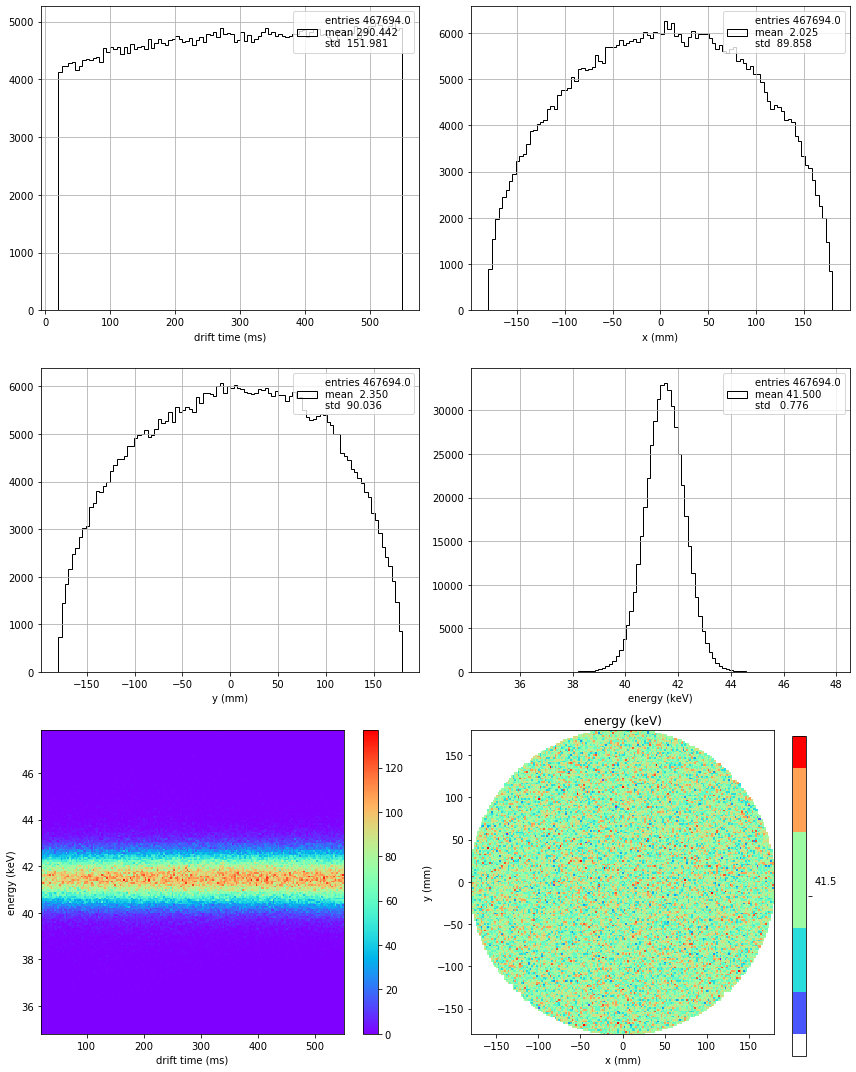

In [43]:
sel = sels['corenergy']
xdf = {'x': mkdst[sel].x, 'y': mkdst[sel].y, 'dtime': mkdst[sel].dtime, 'energy':  mkdst[sel].cor2energy}
xdf = pd.DataFrame(xdf)
krana.plot_data(xdf, bins = 180)

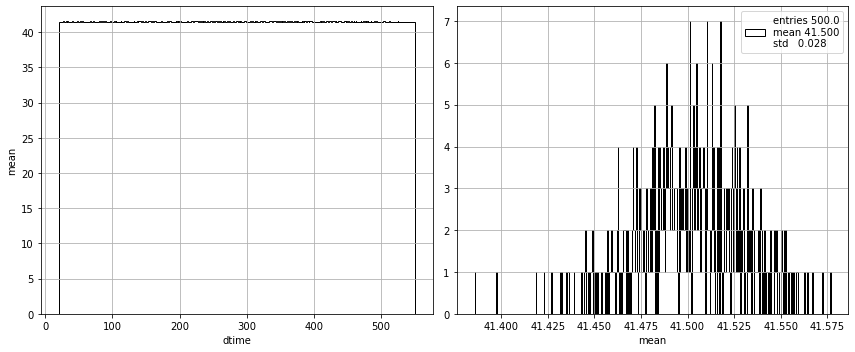

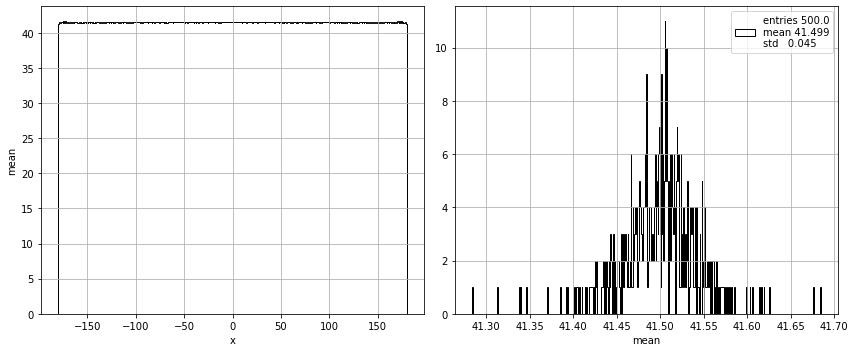

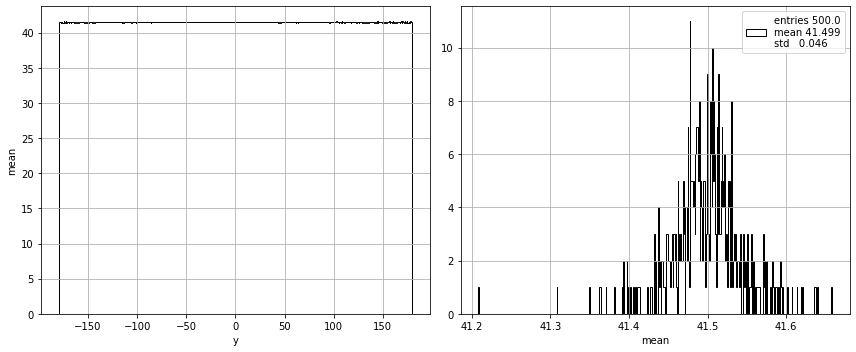

In [44]:
krana.plot_xydt_energy_profiles(xdf[xdf.energy > 0.], nbins = 500)

In [45]:
bin_size = [xyprof.bin_edges[i][1] - xyprof.bin_edges[i][0] for i in (0, 1)]
print('bin size ', bin_size)

bin size  [1.999647058613931, 1.999326748360943]
